In [1]:
#!wget cs231n.stanford.edu/coco-animals.zip
#!unzip coco-animals.zip
#!rm coco-animals.zip

In [ ]:
#from google.colab import drive 
#drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Start Here

In [1]:
pwd

'/home/tp8pj'

In [2]:
cd /home/tp8pj/shared/lsi/TP_sample

/project/sds-capstone-aaai/lsi/TP_sample


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

In [189]:
#import torchvision.models as models
#vgg16 = models.vgg16(pretrained=True)
#print(vgg16)

In [190]:
## debug pip install problems
!pip install --user pyqt5==5.9

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [191]:
## debug pip install problems
!pip install --user msgpack

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [192]:
## debug pip install problems
!pip install --user easydict

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
'''
parser = argparse.ArgumentParser()
parser.add_argument('--train_dir', default='coco-animals/train')
parser.add_argument('--val_dir', default='coco-animals/val')
parser.add_argument('--batch_size', default=32, type=int)
parser.add_argument('--num_workers', default=4, type=int)
parser.add_argument('--num_epochs1', default=10, type=int)
parser.add_argument('--num_epochs2', default=10, type=int)
parser.add_argument('--use_gpu', action='store_true')
'''
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [3]:
import easydict
args = easydict.EasyDict({
    'train_dir' : '/project/sds-capstone-aaai/lsi/TP_sample/train',
    'val_dir'   : '/project/sds-capstone-aaai/lsi/TP_sample/valid',
    'batch_size': 16,
    'num_workers': 4,
    'num_epochs1': 10,
    'num_epochs2': 10,
    'use_gpu' : "store_true"
})

In [4]:
def main(model, args):
  # Figure out the datatype we will use; this will determine whether we run on
  # CPU or on GPU. Run on GPU by adding the command-line flag --use_gpu
  dtype = torch.FloatTensor
  #if args.use_gpu:
   # dtype = torch.cuda.FloatTensor     # Shit, it does not work. So, I gotta fix this cuda error.

  # Use the torchvision.transforms package to set up a transformation to use
  # for our images at training time. The train-time transform will incorporate
  # data augmentation and preprocessing. At training time we will perform the
  # following preprocessing on our images:
  # (1) Resize the image so its smaller side is 256 pixels long
  # (2) Take a random 224 x 224 crop to the scaled image
  # (3) Horizontally flip the image with probability 1/2
  # (4) Convert the image from a PIL Image to a Torch Tensor
  # (5) Normalize the image using the mean and variance of each color channel
  #     computed on the ImageNet dataset.
  train_transform = T.Compose([
    T.Scale(256),
    T.RandomSizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),            
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
  ])
  
  # You load data in PyTorch by first constructing a Dataset object which
  # knows how to load individual data points (images and labels) and apply a
  # transform. The Dataset object is then wrapped in a DataLoader, which iterates
  # over the Dataset to construct minibatches. The num_workers flag to the
  # DataLoader constructor is the number of background threads to use for loading
  # data; this allows dataloading to happen off the main thread. You can see the
  # definition for the base Dataset class here:
  # https://github.com/pytorch/pytorch/blob/master/torch/utils/data/dataset.py
  #
  # and you can see the definition for the DataLoader class here:
  # https://github.com/pytorch/pytorch/blob/master/torch/utils/data/dataloader.py#L262
  #
  # The torchvision package provides an ImageFolder Dataset class which knows
  # how to read images off disk, where the image from each category are stored
  # in a subdirectory.
  #
  # You can read more about the ImageFolder class here:
  # https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py
  train_dset = ImageFolder(args.train_dir, transform=train_transform)
  train_loader = DataLoader(train_dset,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    shuffle=True)

  # Set up a transform to use for validation data at test-time. For validation
  # images we will simply resize so the smaller edge has 224 pixels, then take
  # a 224 x 224 center crop. We will then construct an ImageFolder Dataset object
  # for the validation data, and a DataLoader for the validation set.
  val_transform = T.Compose([
    T.Scale(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
  ])
  val_dset = ImageFolder(args.val_dir, transform=val_transform)
  val_loader = DataLoader(val_dset,
                  batch_size=args.batch_size,
                  num_workers=args.num_workers)

  # Now that we have set up the data, it's time to set up the model.
  # For this example we will finetune a ResNet-18 model which has been
  # pretrained on ImageNet. We will first reinitialize the last layer of the
  # model, and train only the last layer for a few epochs. We will then finetune
  # the entire model on our dataset for a few more epochs.

  # First load the pretrained ResNet-18 model; this will download the model
  # weights from the web the first time you run it.
  #model = torchvision.models.resnet18(pretrained=True)

  # Reinitialize the last layer of the model. Each pretrained model has a
  # slightly different structure, but from the ResNet class definition
  # we see that the final fully-connected layer is stored in model.fc:
  # https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L111
  num_classes = len(train_dset.classes)
  print("----------")
  print(model.fc.in_features)
  print("----------")
  model.fc = nn.Linear(model.fc.in_features, 5+1) ## Final fully-connected layer: How many categories? <- I put +1 to the class bc,
                                                ## bc I got the error: Assertion `cur_target >= 0 && cur_target < n_classes' failed.
                                                ## So, you had to make your index of current target < number of classes.
                                                ## So, I increased the # of classes, but I might have to make the target index start from 0 
  
  # Cast the model to the correct datatype, and create a loss function for
  # training the model.
  model.type(dtype)
  loss_fn = nn.CrossEntropyLoss().type(dtype)

  # First we want to train only the reinitialized last layer for a few epochs.
  # During this phase we do not need to compute gradients with respect to the
  # other weights of the model, so we set the requires_grad flag to False for
  # all model parameters, then set requires_grad=True for the parameters in the
  # last layer only.
  for param in model.parameters():
    param.requires_grad = False
  for param in model.fc.parameters():
    param.requires_grad = True

  # Construct an Optimizer object for updating the last layer only.
  optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

  # Update only the last layer for a few epochs.
  for epoch in range(args.num_epochs1):
    # Run an epoch over the training data.
    print('Starting epoch %d / %d' % (epoch + 1, args.num_epochs1))
    run_epoch(model, loss_fn, train_loader, optimizer, dtype)
    finalmodel = model

    # Check accuracy on the train and val sets.
    train_acc = check_accuracy(model, train_loader, dtype)
    val_acc = check_accuracy(model, val_loader, dtype)
    print('Train accuracy: ', train_acc)
    print('Val accuracy: ', val_acc)

  # Now we want to finetune the entire model for a few epochs. To do this we
  # will need to compute gradients with respect to all model parameters, so
  # we flag all parameters as requiring gradients.
  for param in model.parameters():
    param.requires_grad = True
  
  # Construct a new Optimizer that will update all model parameters. Note the
  # small learning rate.
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

  # Train the entire model for a few more epochs, checking accuracy on the
  # train and validation sets after each epoch.
  for epoch in range(args.num_epochs2):
    print('Starting epoch %d / %d' % (epoch + 1, args.num_epochs2))
    run_epoch(model, loss_fn, train_loader, optimizer, dtype)

    train_acc = check_accuracy(model, train_loader, dtype)
    val_acc = check_accuracy(model, val_loader, dtype)
    print('Train accuracy: ', train_acc)
    print('Val accuracy: ', val_acc)
  #finalmodel = model
# image = process_image('/content/gdrive/My Drive/ch7&9/Test/18_AROGERSIG_10312566278.jpg')

  

In [13]:
"""
model = torchvision.models.resnet18(pretrained=True)
train_transform = T.Compose([
    T.Scale(256),
    T.RandomSizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),            
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
  ])
train_dset = ImageFolder(args.train_dir, transform=train_transform)
print(train_dset.classes)
num_classes = len(train_dset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
"""

'\nmodel = torchvision.models.resnet18(pretrained=True)\ntrain_transform = T.Compose([\n    T.Scale(256),\n    T.RandomSizedCrop(224),\n    T.RandomHorizontalFlip(),\n    T.ToTensor(),            \n    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),\n  ])\ntrain_dset = ImageFolder(args.train_dir, transform=train_transform)\nprint(train_dset.classes)\nnum_classes = len(train_dset.classes)\nmodel.fc = nn.Linear(model.fc.in_features, num_classes)\n'

In [5]:
def run_epoch(model, loss_fn, loader, optimizer, dtype):
  """
  Train the model for one epoch.
  """
  # Set the model to training mode
  model.train()
  for x, y in loader:
    # The DataLoader produces Torch Tensors, so we need to cast them to the
    # correct datatype and wrap them in Variables.
    #
    # Note that the labels should be a torch.LongTensor on CPU and a
    # torch.cuda.LongTensor on GPU; to accomplish this we first cast to dtype
    # (either torch.FloatTensor or torch.cuda.FloatTensor) and then cast to
    # long; this ensures that y has the correct type in both cases.
    x_var = Variable(x.type(dtype))
    y_var = Variable(y.type(dtype).long())

    # Run the model forward to compute scores and loss.
    scores = model(x_var)
    loss = loss_fn(scores, y_var)

    # Run the model backward and take a step using the optimizer.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [6]:
def check_accuracy(model, loader, dtype):
  """
  Check the accuracy of the model.
  """
  # Set the model to eval mode
  model.eval()
  num_correct, num_samples = 0, 0
  for x, y in loader:
    # Cast the image data to the correct type and wrap it in a Variable. At
    # test-time when we do not need to compute gradients, marking the Variable
    # as volatile can reduce memory usage and slightly improve speed.
    x_var = Variable(x.type(dtype), volatile=True)

    # Run the model forward, and compare the argmax score with the ground-truth
    # category.
    scores = model(x_var)
    _, preds = scores.data.cpu().max(1)
    num_correct += (preds == y).sum()
    num_samples += x.size(0)

  # Return the fraction of datapoints that were correctly classified.
  acc = float(num_correct) / num_samples
  return acc

In [16]:
#CUDA_LAUNCH_BLOCKING=1

In [7]:
#if __name__ == '__main__':
#  print("love")
model1 = torchvision.models.resnet18(pretrained=True) # This is the model I use
model = model1 #.cuda() # I cast the model to gpu by using .cuda
main(model, args) # I run my model which has trained by transfer learningbb

----------
512
----------
Starting epoch 1 / 10


/home/tp8pj/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/tp8pj/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:704: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Train accuracy:  0.5598958333333334
Val accuracy:  0.5545454545454546
Starting epoch 2 / 10
Train accuracy:  0.6458333333333334
Val accuracy:  0.6181818181818182
Starting epoch 3 / 10
Train accuracy:  0.7057291666666666
Val accuracy:  0.6636363636363637
Starting epoch 4 / 10
Train accuracy:  0.71875
Val accuracy:  0.6909090909090909
Starting epoch 5 / 10
Train accuracy:  0.7265625
Val accuracy:  0.7
Starting epoch 6 / 10
Train accuracy:  0.7421875
Val accuracy:  0.7272727272727273
Starting epoch 7 / 10
Train accuracy:  0.7161458333333334
Val accuracy:  0.6636363636363637
Starting epoch 8 / 10
Train accuracy:  0.7291666666666666
Val accuracy:  0.6818181818181818
Starting epoch 9 / 10
Train accuracy:  0.796875
Val accuracy:  0.7090909090909091
Starting epoch 10 / 10
Train accuracy:  0.7630208333333334
Val accuracy:  0.7454545454545455
Starting epoch 1 / 10
Train accuracy:  0.7682291666666666
Val accuracy:  0.7363636363636363
Starting epoch 2 / 10
Train accuracy:  0.8229166666666666
Val a

In [8]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [9]:
dtype = torch.FloatTensor

In [14]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    # output = torch.exp(output)
    
    # x_var = Variable(image.type(dtype), volatile=True)

    # Run the model forward, and compare the argmax score with the ground-truth
    # category.
    # scores = model(x_var)
    # a, preds = scores.data.cpu().max(1)
    # num_correct += (preds == y).sum()
    # num_samples += x.size(0)
    # print(a)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [15]:
# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [18]:
import pandas as pd
import glob
img_dir = "/project/sds-capstone-aaai/lsi/TP_sample/test" # Enter Directory of all images 
all_files = glob.glob(img_dir + "/*.jpg") # list of all images

In [19]:
import numpy as np
from PIL import Image
image = process_image(all_files[0])

In [152]:
# Give image to model to predict output
# top_prob, top_class = predict(image, model) # cast an image to GPU by using .cuda(). If you waana use cpu, delete .cuda().

In [20]:
import matplotlib.pyplot as plt
# Show the image
show_image(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [21]:
class_dir = "/project/sds-capstone-aaai/lsi/TP_sample/train" # Enter Directory of all classes 
class_name = glob.glob(class_dir + "/*") # list of all images
class_name

['/project/sds-capstone-aaai/lsi/TP_sample/train/specimen',
 '/project/sds-capstone-aaai/lsi/TP_sample/train/hedge',
 '/project/sds-capstone-aaai/lsi/TP_sample/train/tapis',
 '/project/sds-capstone-aaai/lsi/TP_sample/train/grotto',
 '/project/sds-capstone-aaai/lsi/TP_sample/train/arcade']

In [22]:
classes = ['x', 'arcade', 'grotto', 'hedge', 'specimen', 'tapis']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted the image as tapis
The model predicted the image as hedge
The model predicted the image as arcade


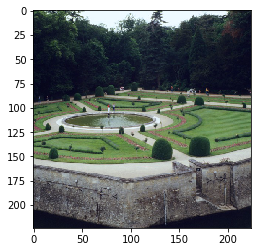

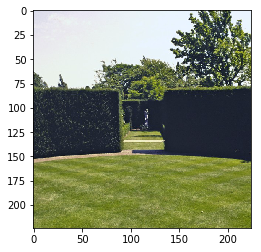

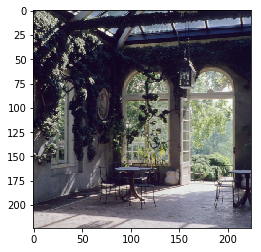

In [23]:
for file_name in all_files: # By using forloop, I print out multiple images in the test folder. Also, check how those images are classified.
  image = process_image(file_name)
  top_prob, top_class = predict(image, model) #.cuda cast images to GPU.
  show_image(image)
  # print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class  )
  #for i in classes:
   # if top_class == classes.index(i):
  print("The model predicted the image as", classes[top_class])  

In [ ]:
print(model)
finalmodel = torchvision.models.resnet18(pretrained=True)
print(finalmodel)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  